In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

In [3]:
WORKING_DIRECTORY = './drive/MyDrive/Colab\ Notebooks/diploma/'

In [4]:
 # Создаём SparkSession
spark = SparkSession.builder \
    .appName("PetCo") \
    .getOrCreate()

In [5]:
# Read dataset with beh logs
data_logs = spark.read.parquet(WORKING_DIRECTORY+'data/needed_beh_logs')

In [6]:
data_logs.show()

+----------------+--------------------+-----+--------------------+--------------------+--------------------+-----------------+-------------+--------------------+--------------------+-----------+--------------------+------------+--------------------+--------------------+--------------------+-------+
|customer_user_id|              ac_key|ac_id|             user_id|          session_id|           timestamp|         raw_term|  filter_name|        filter_value|              action|customer_id|           item_name|variation_id|      variation_name|               items|            items_v2|revenue|
+----------------+--------------------+-----+--------------------+--------------------+--------------------+-----------------+-------------+--------------------+--------------------+-----------+--------------------+------------+--------------------+--------------------+--------------------+-------+
|       435675978|key_afiSr5Y4gCaaSW5X| 2560|e5fbf045-94fa-498...|e5fbf045-94fa-498...|2024-11-29 10

In [7]:
data_logs.printSchema()  # Структура данных

root
 |-- customer_user_id: string (nullable = true)
 |-- ac_key: string (nullable = true)
 |-- ac_id: long (nullable = true)
 |-- user_id: string (nullable = true)
 |-- session_id: string (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- raw_term: string (nullable = true)
 |-- filter_name: string (nullable = true)
 |-- filter_value: string (nullable = true)
 |-- action: string (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- item_name: string (nullable = true)
 |-- variation_id: long (nullable = true)
 |-- variation_name: string (nullable = true)
 |-- items: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- customer_id: string (nullable = true)
 |    |    |-- item_id: long (nullable = true)
 |    |    |-- item_name: string (nullable = true)
 |    |    |-- price: double (nullable = true)
 |-- items_v2: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- customer_id: string (nullabl

In [8]:
print(f'Число строк: {data_logs.count()}')

Число строк: 5465431


In [25]:
n_users = data_logs.select('customer_user_id').distinct().count()
print(f'Число пользователей: {n_users}')

Число пользователей: 20000


In [10]:
# Предположим, что df — это ваш DataFrame
#data_logs = data_logs.withColumn("timestamp", F.col("timestamp").cast("timestamp"))
data_logs = data_logs.withColumn("formatted_timestamp", F.date_format("timestamp", "yyyy-MM-dd HH:mm:ss"))
# Нахождение минимальной и максимальной даты
min_date = data_logs.agg(F.min("formatted_timestamp").alias("min_date")).collect()[0]["min_date"]
max_date = data_logs.agg(F.max("formatted_timestamp").alias("max_date")).collect()[0]["max_date"]

print(f"Разброс дат: {min_date, max_date}")

Разброс дат: ('2024-06-06 00:00:09', '2024-12-02 23:59:55')


In [18]:
# Группируем по 'user_id' и считаем количество строк для каждого 'user_id'
user_counts = data_logs.groupBy("customer_user_id").count()
average_count = user_counts.agg(F.avg("count")).collect()[0][0]
median_count = user_counts.approxQuantile('count', [0.5], 0.01)[0]

print(f"Среднее число итеракций: {round(average_count, 1)}")
print(f'Медианное число итеракций: {median_count}')

Среднее число итеракций: 273.3
Медианное число итеракций: 208.0


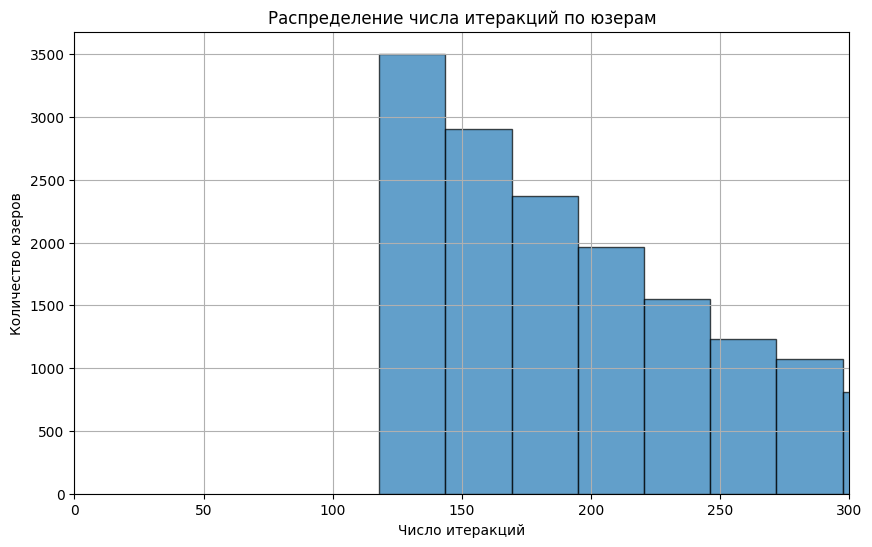

In [19]:
# Преобразуем в pandas DataFrame
user_counts_pd = user_counts.toPandas()

# Строим гистограмму распределения
plt.figure(figsize=(10, 6))
plt.hist(user_counts_pd['count'], bins=400, edgecolor='black', alpha=0.7)
plt.title("Распределение числа итеракций по юзерам")
plt.xlabel("Число итеракций")
plt.ylabel("Количество юзеров")
plt.grid(True)
plt.xlim(left=0, right=300)
plt.show()

In [77]:
data_purchases = data_logs.filter(data_logs.action == 'purchase')
print(f'Number of group purchases: {data_purchases.count()}')

Number of group purchases: 98248


In [14]:
data_purchases.show()

+----------------+--------------------+-----+--------------------+--------------------+--------------------+--------+-----------+------------+--------+-----------+---------+------------+--------------+--------------------+--------------------+-------+-------------------+
|customer_user_id|              ac_key|ac_id|             user_id|          session_id|           timestamp|raw_term|filter_name|filter_value|  action|customer_id|item_name|variation_id|variation_name|               items|            items_v2|revenue|formatted_timestamp|
+----------------+--------------------+-----+--------------------+--------------------+--------------------+--------+-----------+------------+--------+-----------+---------+------------+--------------+--------------------+--------------------+-------+-------------------+
|       635619080|key_afiSr5Y4gCaaSW5X| 1947|6521ca44-0aed-409...|6521ca44-0aed-409...|2024-11-29 01:34:...|    NULL|       NULL|        NULL|purchase|       NULL|     NULL|        NUL

In [70]:
from pyspark.sql import functions as F
from pyspark.sql.types import IntegerType, Row

# Создание UDF для подсчета длины списка в атрибуте items
count_items_udf = F.udf(lambda row: len(row), IntegerType())

# Применение UDF
items_counts = data_purchases.withColumn("items_count", count_items_udf(F.col("items"))).select('items_count')
items_counts.show()
avg_items_count = items_counts.agg(F.avg('items_count')).collect()[0][0]
print(f'Среднее число товаров в одной покупке: {avg_items_count}')

+-----------+
|items_count|
+-----------+
|          3|
|          9|
|          4|
|          4|
|          1|
|          2|
|          4|
|          1|
|          8|
|          3|
|          2|
|          2|
|          1|
|         12|
|          2|
|          3|
|          3|
|         10|
|          2|
|          1|
+-----------+
only showing top 20 rows

Среднее число товаров в одной покупке: 3.455449474798469


In [52]:
# items_0 = data_purchases.select('items').collect()[0]
print(items_0)
print(len(items_0.items))
print(items_0.items)

Row(items=[Row(customer_id='5190834', item_id=6123021896, item_name='EveryYay Bowl Lid for Dogs', price=None), Row(customer_id='5025044', item_id=3668995058, item_name='Blue Buffalo True Chews Made in the USA with Natural Ingredients, Steak Premium Grillers Dog Treats', price=None), Row(customer_id='5025045', item_id=3668995054, item_name='Blue Buffalo True Chews Premium Jerky Cuts with Natural Ingredients Chicken Dog Treats', price=None)])
3
[Row(customer_id='5190834', item_id=6123021896, item_name='EveryYay Bowl Lid for Dogs', price=None), Row(customer_id='5025044', item_id=3668995058, item_name='Blue Buffalo True Chews Made in the USA with Natural Ingredients, Steak Premium Grillers Dog Treats', price=None), Row(customer_id='5025045', item_id=3668995054, item_name='Blue Buffalo True Chews Premium Jerky Cuts with Natural Ingredients Chicken Dog Treats', price=None)]


In [71]:
items_v2_0 = data_purchases.select('items_v2').collect()[0]
print(len(items_v2_0))
print(items_v2_0)

1
Row(items_v2=[Row(customer_id='5190834', item_id=6123021896, item_name='EveryYay Bowl Lid for Dogs', price=None, variation_customer_id='3764305', variation_id=1864390900, variation_name='EveryYay Bowl Lid for Dogs, Small, Pack of 2', count=1), Row(customer_id='5025044', item_id=3668995058, item_name='Blue Buffalo True Chews Made in the USA with Natural Ingredients, Steak Premium Grillers Dog Treats', price=None, variation_customer_id='3578895', variation_id=1864382465, variation_name='Blue Buffalo True Chews Natural Premium Steak Grillers Dog Treats, 30 oz.', count=1), Row(customer_id='5025045', item_id=3668995054, item_name='Blue Buffalo True Chews Premium Jerky Cuts with Natural Ingredients Chicken Dog Treats', price=None, variation_customer_id='3322443', variation_id=365342414, variation_name='Blue Buffalo True Chews Premium Jerky Cuts with Natural Ingredients Chicken Dog Treats, 32 oz.', count=1)])


In [21]:
n_users_purchased = data_purchases.select('customer_user_id').distinct().count()
print(f'Число пользователей, которые сделали покупки: {n_users_purchased}')

Число пользователей, которые сделали покупки: 17884


In [22]:
# Группируем по 'customer_user_id' и считаем количество строк для каждого 'customer_user_id'
user_counts_purchased = data_purchases.groupBy("customer_user_id").count()
average_count_purchases = user_counts_purchased.agg(F.avg("count")).collect()[0][0]
median_count_purchases = user_counts_purchased.approxQuantile('count', [0.5], 0.01)[0]

print(f"Среднее число покупок: {round(average_count_purchases, 1)}")
print(f'Медианное число покупок: {median_count_purchases}')

Среднее число покупок: 5.5
Медианное число покупок: 4.0


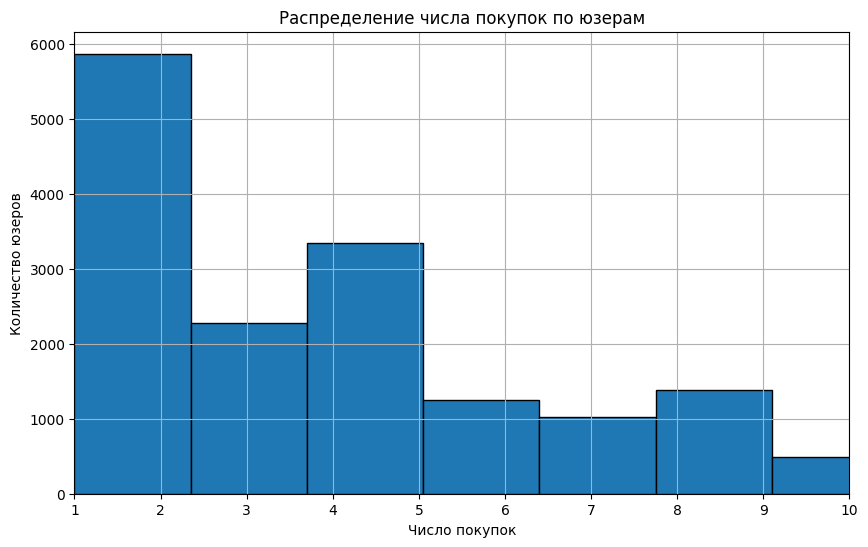

In [23]:
# Преобразуем в pandas DataFrame
user_counts_pd_purchases = user_counts_purchased.toPandas()

# Строим гистограмму распределения
plt.figure(figsize=(10, 6))
plt.hist(user_counts_pd_purchases['count'], bins=100, edgecolor='black')
plt.title("Распределение числа покупок по юзерам")
plt.xlabel("Число покупок")
plt.ylabel("Количество юзеров")
plt.grid(True)
plt.xlim(left=1, right=10)
plt.show()

In [75]:
single_purchases = items_counts.agg(F.sum('items_count')).collect()[0][0]
n_items = 32000
print(f'Total number of purchases : {single_purchases}')
print(f'Average number of purchases per item: {single_purchases/n_items}')

Total number of purchases : 339491
Average number of purchases per item: 10.60909375


# **Вывод**

Можно брать за отдельного юзера отдельный user_id (id незалогированного юзера) или отдельный customer_user_id (id залогированного юзера). Если брать user_id: юзеров около 70 тысяч (хорошо), средняя длина групповых покупок 1.8, а единичных - 7 (маловато, но можно). Если брать customer_user_id: юзеров 18 тысяч (достаточно), средняя длина групповых покупок 5.5, а единичных покупок 19 (хорошо, в статье с Амазоном 7.6). Логично рассматривать customer_user_id, так как они обозначают одних и тех же людей, в то время как user_id разбивает одного юзера на серии покупок (что излишне).

Всего групповых покупок около 98 тысяч, а единичных - 339 тысяч, в среднем за одну покупку покупается около 3.5 товаров.

Также каждый товар покупается в среднем 10.6 раз

# **Вопросы:**

1. Какую давать последовательность товарам внутри одной групповой покупки
(одинаковую, или порядок их занесения в корзину, или тот порядок, как они уже находятся в столбце 'items')
2. Надо же рассматривать именно единичные покупки? (вроде, да)